<a href="https://colab.research.google.com/github/khaled-kk/Metaheuristic-Driven-Feature-Selection-in-Deep-Neural-Networks-for-Automated-Brain-Tumour-Detection/blob/main/Metaheuristic-Driven-Feature-Selection-in-Deep-Neural-Networks-for-Automated-Brain-Tumour-Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50,DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch
from sklearn.neighbors import NearestNeighbors

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Update these paths to where you uploaded the folder in your Drive
# Usually it's /content/drive/MyDrive/your_folder_name
base_path = '/content/drive/MyDrive/archive'
train_path = os.path.join(base_path, 'Training')
test_path = os.path.join(base_path, 'Testing')

# Now run the rest of the data generator code...

Mounted at /content/drive


In [ ]:
# DATA PREPROCESSING

# CNN / ANN
cnn_train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

cnn_test_datagen = ImageDataGenerator(rescale=1./255)

# VGG16
vgg_train_datagen = ImageDataGenerator(
    preprocessing_function=vgg_preprocess,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

vgg_test_datagen = ImageDataGenerator(
    preprocessing_function=vgg_preprocess
)

# ResNet50
resnet_train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

resnet_test_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess
)

# -------------------------------
# GENERATORS
# -------------------------------

cnn_train_generator = cnn_train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

cnn_val_generator = cnn_train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

cnn_test_generator = cnn_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

vgg_train_generator = vgg_train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

vgg_val_generator = vgg_train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

vgg_test_generator = vgg_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

resnet_train_generator = resnet_train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

resnet_val_generator = resnet_train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

resnet_test_generator = resnet_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


# MODEL BUILDING FUNCTION
def build_and_train(model_name='VGG16'):
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        train_gen, val_gen = vgg_train_generator, vgg_val_generator
    else:
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        train_gen, val_gen = resnet_train_generator, resnet_val_generator

    # -------- STAGE 1 --------
    base_model.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(base_model.input, output)
    model.compile(
        optimizer=Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(train_gen, validation_data=val_gen, epochs=5)

    # -------- STAGE 2 (FINE-TUNING) --------
    base_model.trainable = True
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    model.compile(
        optimizer=Adam(1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(train_gen, validation_data=val_gen, epochs=5)

    return model

# EXECUTE MODELS
vgg_model = build_and_train('VGG16')
resnet_model = build_and_train('ResNet50')
vgg_model.save("vgg16_model.h5")
resnet_model.save("resnet50_model.h5")
print("VGG16 and ResNet50 models saved")




Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 1289s 9s/step - accuracy: 0.6894 - loss: 4.2102 - val_accuracy: 0.7642 - val_loss: 1.0294
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 679ms/step - accuracy: 0.8463 - loss: 0.4675 - val_accuracy: 0.7677 - val_loss: 0.9323
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 675ms/step - accuracy: 0.8843 - loss: 0.3438 - val_accuracy: 0.8063 - val_loss: 0.7119
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 671ms/step - accuracy: 0.8997 - loss: 0.3081 - val_accuracy: 0.8212 - val_loss: 0.6838
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 676ms/step - accuracy: 0.9127 - loss: 0.2866 - val_accuracy: 0.8256 - val_loss: 0.7277
Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 139s 829ms/step - accuracy: 0.9296 - loss: 0.2148 - val_accuracy: 0.8501 - val_loss: 0.6247
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 709ms/step - accuracy: 0.9415 - loss: 0.1738 - val_accuracy: 0.8703 - val_loss: 0.4983
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 103s 719ms/step - accuracy: 0.9489 - loss: 0.1418 

VGG16 and ResNet50 models saved


In [ ]:
# ==============================
# FINAL TEST ACCURACY CHECK
# ==============================

print("\n--- Final Test Accuracy ---")

vgg_acc = vgg_model.evaluate(vgg_test_generator, verbose=0)[1]
res_acc = resnet_model.evaluate(resnet_test_generator, verbose=0)[1]

print(f"VGG16 Accuracy: {vgg_acc*100:.2f}%")
print(f"ResNet50 Accuracy: {res_acc*100:.2f}%")


--- Final Test Accuracy ---
VGG16 Accuracy: 92.45%
ResNet50 Accuracy: 92.52%


Training Custom CNN...
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 104s 687ms/step - accuracy: 0.4718 - loss: 1.4923 - val_accuracy: 0.6582 - val_loss: 0.9151
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 653ms/step - accuracy: 0.7474 - loss: 0.6283 - val_accuracy: 0.6959 - val_loss: 0.8230
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 661ms/step - accuracy: 0.7859 - loss: 0.5294 - val_accuracy: 0.7353 - val_loss: 0.7424
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 654ms/step - accuracy: 0.8107 - loss: 0.4938 - val_accuracy: 0.7274 - val_loss: 0.7022
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 650ms/step - accuracy: 0.8309 - loss: 0.4384 - val_accuracy: 0.7616 - val_loss: 0.6474
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 652ms/step - accuracy: 0.8528 - loss: 0.4039 - val_accuracy: 0.7634 - val_loss: 0.6337
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 661ms/step - accuracy: 0.8455 - loss: 0.3951 - val_accuracy: 0.7721 - val_loss: 0.6324
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 647ms/step - ac

CNN model saved


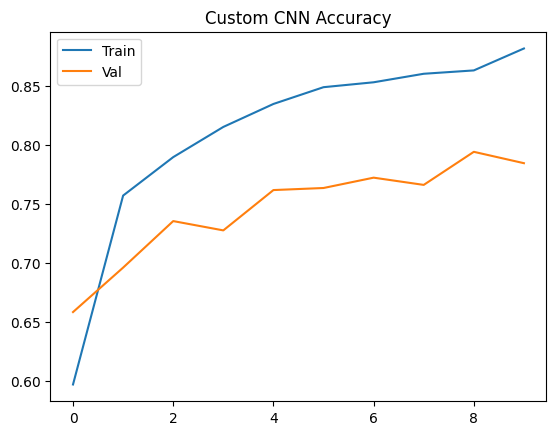

In [ ]:
# BUILD CNN WITH INPUT LAYER (Removes UserWarning)

def build_custom_cnn():
    model = Sequential([
        Input(shape=(224, 224, 3)), # Modern way to define input
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_custom_cnn()
print("Training Custom CNN...")
cnn_history = cnn_model.fit(cnn_train_generator,validation_data=cnn_val_generator,epochs=10)
cnn_model.save("cnn_baseline.h5")
print("CNN model saved")


# Plotting CNN
plt.plot(cnn_history.history['accuracy'], label='Train')
plt.plot(cnn_history.history['val_accuracy'], label='Val')
plt.title('Custom CNN Accuracy')
plt.legend()
plt.show()

Training Basic ANN...
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 672ms/step - accuracy: 0.3277 - loss: 10.6875 - val_accuracy: 0.3611 - val_loss: 1.3595
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 637ms/step - accuracy: 0.3951 - loss: 1.2451 - val_accuracy: 0.3287 - val_loss: 1.3349
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 630ms/step - accuracy: 0.4287 - loss: 1.1981 - val_accuracy: 0.5022 - val_loss: 1.1673
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 638ms/step - accuracy: 0.4720 - loss: 1.1322 - val_accuracy: 0.5311 - val_loss: 1.1797
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 680ms/step - accuracy: 0.5132 - loss: 1.1122 - val_accuracy: 0.4794 - val_loss: 1.2234
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 643ms/step - accuracy: 0.5137 - loss: 1.0793 - val_accuracy: 0.5013 - val_loss: 1.1987
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 629ms/step - accuracy: 0.5149 - loss: 1.0922 - val_accuracy: 0.5478 - val_loss: 1.1593
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 633ms/step - acc

ANN model saved


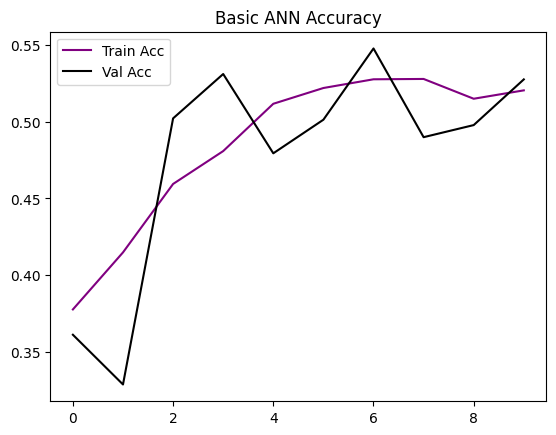

In [ ]:
def build_ann():
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Flatten(), # This loses the spatial 'shape' of the brain
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Training
ann_model = build_ann()
print("Training Basic ANN...")
ann_history = ann_model.fit(cnn_train_generator,validation_data=cnn_val_generator,epochs=10)
ann_model.save("ann_model.h5")
print("ANN model saved")


# Visualization
plt.plot(ann_history.history['accuracy'], label='Train Acc', color='purple')
plt.plot(ann_history.history['val_accuracy'], label='Val Acc', color='black')
plt.title('Basic ANN Accuracy')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler


In [ ]:
# ==============================
# DenseNet121 MODEL
# ==============================

densenet_base = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

densenet_base.trainable = False

x = Flatten()(densenet_base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(4, activation="softmax")(x)

densenet_model = Model(densenet_base.input, output)

densenet_model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

densenet_model.fit(
    cnn_train_generator,
    validation_data=cnn_val_generator,
    epochs=5
)

# Fine-tuning
densenet_base.trainable = True
for layer in densenet_base.layers[:-20]:
    layer.trainable = False

densenet_model.compile(
    optimizer=Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

densenet_model.fit(
    cnn_train_generator,
    validation_data=cnn_val_generator,
    epochs=5
)

densenet_model.save("densenet121_model.h5")
print("✅ DenseNet121 model saved")


Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 168s 987ms/step - accuracy: 0.7064 - loss: 1.1211 - val_accuracy: 0.7800 - val_loss: 0.6234
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 708ms/step - accuracy: 0.8717 - loss: 0.3415 - val_accuracy: 0.8221 - val_loss: 0.4929
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 106s 745ms/step - accuracy: 0.9034 - loss: 0.2710 - val_accuracy: 0.8221 - val_loss: 0.4796
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 691ms/step - accuracy: 0.9094 - loss: 0.2508 - val_accuracy: 0.8396 - val_loss: 0.4582
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 693ms/step - accuracy: 0.9131 - loss: 0.2276 - val_accuracy: 0.8571 - val_loss: 0.4039
Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 165s 934ms/step - accuracy: 0.9350 - loss: 0.1945 - val_accuracy: 0.8519 - val_loss: 0.4519
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 102s 714ms/step - accuracy: 0.9563 - loss: 0.1278 - val_accuracy: 0.8580 - val_loss: 0.4215
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 692ms/step - accuracy: 0.9466 - loss: 0.14

✅ DenseNet121 model saved


In [ ]:
# ==============================
# FEATURE EXTRACTORS
# ==============================

# 🔹 Force a forward pass to initialize the models
_ = cnn_model.predict(cnn_train_generator, steps=1)
_ = vgg_model.predict(vgg_train_generator, steps=1)
_ = resnet_model.predict(resnet_train_generator, steps=1)
_ = densenet_model.predict(cnn_train_generator, steps=1)

# CNN
cnn_extractor = Model(
    inputs=cnn_model.inputs,
    outputs=cnn_model.layers[-3].output
)

# VGG16
vgg_extractor = Model(
    inputs=vgg_model.inputs,
    outputs=vgg_model.layers[-3].output
)

# ResNet50
resnet_extractor = Model(
    inputs=resnet_model.inputs,
    outputs=resnet_model.layers[-2].output
)

# DenseNet121
densenet_extractor = Model(
    inputs=densenet_model.inputs,
    outputs=densenet_model.layers[-3].output
)


print("✅ Feature extractors ready")

print("✅ Feature extractors built successfully")

# ==============================
# FEATURE EXTRACTION
# ==============================

cnn_features = cnn_extractor.predict(cnn_train_generator, verbose=1)
vgg_features = vgg_extractor.predict(vgg_train_generator, verbose=1)
resnet_features = resnet_extractor.predict(resnet_train_generator, verbose=1)
densenet_features = densenet_extractor.predict(cnn_train_generator, verbose=1)

labels = cnn_train_generator.classes

# ==============================
# FEATURE NORMALIZATION
# ==============================

scaler = StandardScaler()

cnn_features = scaler.fit_transform(cnn_features)
vgg_features = scaler.fit_transform(vgg_features)
resnet_features = scaler.fit_transform(resnet_features)
densenet_features = scaler.fit_transform(densenet_features)


print("✅ Features normalized")

# ==============================
# SAVE FEATURES
# ==============================

np.save("cnn_features.npy", cnn_features)
np.save("vgg_features.npy", vgg_features)
np.save("resnet_features.npy", resnet_features)
np.save("densenet_features.npy", densenet_features)
np.save("labels.npy", labels)


print("✅ Feature extraction completed and saved.")
print("CNN features shape:", cnn_features.shape)
print("VGG features shape:", vgg_features.shape)
print("ResNet features shape:", resnet_features.shape)
print("DenseNet features shape:", densenet_features.shape)
print("Labels shape:", labels.shape)

# 🔹 Safety checks
assert cnn_features.shape[0] == labels.shape[0]
assert vgg_features.shape[0] == labels.shape[0]
assert resnet_features.shape[0] == labels.shape[0]
assert densenet_features.shape[0] == labels.shape[0]

print("✅ Feature-label alignment verified")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
✅ Feature extractors ready
✅ Feature extractors built successfully
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 494ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 560ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 542ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 614ms/step
✅ Features normalized
✅ Feature extraction completed and saved.
CNN features shape: (4571, 128)
VGG features shape: (4571, 256)
ResNet features shape: (4571, 256)
DenseNet features shape: (4571, 256)
Labels shape: (4571,)
✅ Feature-label alignment verified


In [ ]:
# -----------------------------
# GWO FEATURE SELECTION
# -----------------------------
def gwo_feature_selection(X, y, wolves=10, iters=20):
    n_features = X.shape[1]
    population = np.random.randint(0, 2, size=(wolves, n_features))

    def fitness(mask):
        if np.sum(mask) == 0:
            return 0
        # Use simple SVM accuracy as fitness
        X_sel = X[:, mask == 1]
        X_tr, X_te, y_tr, y_te = train_test_split(
            X_sel, y, test_size=0.2, stratify=y, random_state=42
        )
        clf = SVC(kernel="rbf")
        clf.fit(X_tr, y_tr)
        return accuracy_score(y_te, clf.predict(X_te))

    for _ in range(iters):
        scores = np.array([fitness(w) for w in population])
        alpha = population[np.argmax(scores)]
        # Update wolves
        for i in range(wolves):
            r = np.random.rand(n_features)
            population[i] = np.where(r < 0.5, alpha, population[i])

    best_mask = population[np.argmax(scores)]
    return X[:, best_mask == 1]

# -----------------------------
# RUN GWO ON DenseNet FEATURES
# -----------------------------
X_selected = gwo_feature_selection(densenet_features, labels)
print("✅ GWO selected features shape:", X_selected.shape)

# -----------------------------
# TRAIN FINAL CLASSIFIER (SVM)
# -----------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X_selected,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

svm = SVC(kernel="rbf", probability=True)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

densenet_gwo_acc = accuracy_score(y_test, y_pred) * 100
print(f"✅ DenseNet + GWO Accuracy: {densenet_gwo_acc:.2f}%")

print("✅ FINAL RESULTS")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


✅ GWO selected features shape: (4571, 120)
✅ DenseNet + GWO Accuracy: 29.40%
✅ FINAL RESULTS
Accuracy: 0.2939890710382514
              precision    recall  f1-score   support

           0       0.30      0.09      0.14       212
           1       0.27      0.13      0.18       215
           2       0.29      0.57      0.38       255
           3       0.32      0.33      0.32       233

    accuracy                           0.29       915
   macro avg       0.29      0.28      0.25       915
weighted avg       0.29      0.29      0.26       915



Found 1311 images belonging to 4 classes.

Calculating accuracies on the Test Set...

--- Final Model Performance Comparison ---
     Model Architecture  Test Accuracy (%)  Test Loss                          Feature Extraction
    ResNet(Pre-trained)          92.524791   0.236173                           Residual Learning
     VGG16(Pre-trained)          92.448515   0.332399                           Transfer Learning
  DenseNet(Pre-trained)          92.448515   0.226217                          Dense Connectivity
             Custom CNN          81.922197   0.454348                        Learned from scratch
              Basic ANN          62.852782   1.012585                        Pixel-based (Linear)
DenseNet121 + GWO + SVM          29.398907        NaN DenseNet Features + Metaheuristic Selection


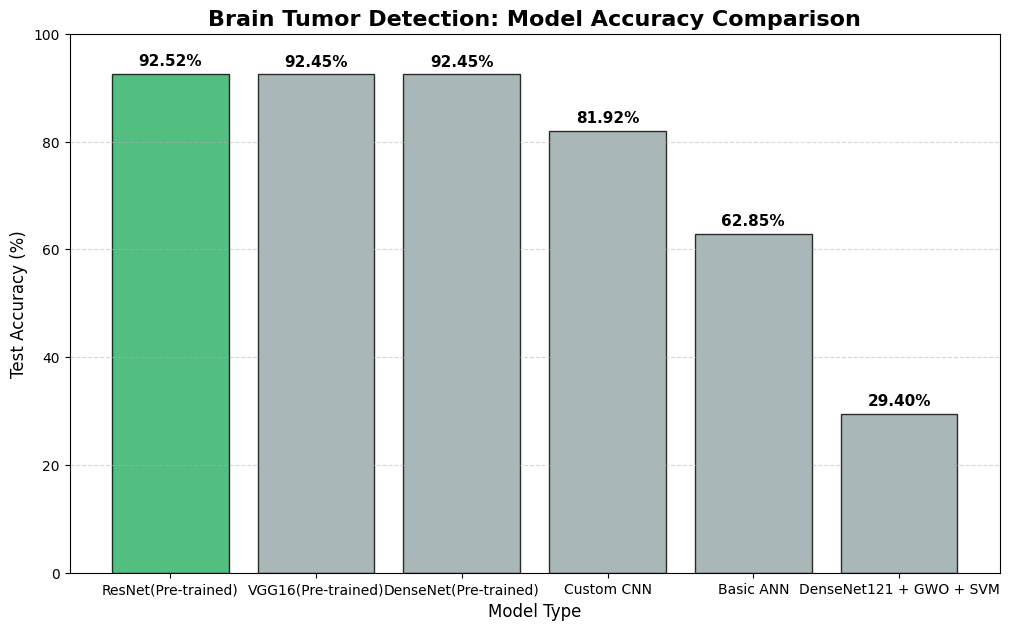

In [ ]:
ann_model = load_model("ann_model.h5")
cnn_model = load_model("cnn_baseline.h5")
vgg_model = load_model("vgg16_model.h5")
resnet_model = load_model("resnet50_model.h5")
densenet_model = load_model("densenet121_model.h5")
densenet_features = np.load("densenet_features.npy")


# 1. RE-INITIALIZE TEST GENERATOR (Prevents NameError)
base_path = '/content/drive/MyDrive/archive'
test_path = os.path.join(base_path, 'Testing')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# 2. EVALUATE ALL MODELS
print("\nCalculating accuracies on the Test Set...")
# We use .evaluate() to get [loss, accuracy]
ann_res = ann_model.evaluate(cnn_test_generator, verbose=0)
cnn_res = cnn_model.evaluate(cnn_test_generator, verbose=0)
vgg_res = vgg_model.evaluate(vgg_test_generator, verbose=0)
res_res = resnet_model.evaluate(resnet_test_generator, verbose=0)
densenet_res = densenet_model.evaluate(cnn_test_generator, verbose=0)


# 3. CONSTRUCT THE ANALYSIS TABLE
data = {
    'Model Architecture': [
        'Basic ANN',
        'Custom CNN',
        'VGG16(Pre-trained)',
        'ResNet(Pre-trained)',
        'DenseNet(Pre-trained)',
        'DenseNet121 + GWO + SVM'
    ],
    'Test Accuracy (%)': [
        ann_res[1] * 100,
        cnn_res[1] * 100,
        vgg_res[1] * 100,
        res_res[1] * 100,
        densenet_res[1] * 100,
        densenet_gwo_acc
    ],
    'Test Loss': [
        ann_res[0],
        cnn_res[0],
        vgg_res[0],
        res_res[0],
        densenet_res[0],
        None
    ],
    'Feature Extraction': [
        'Pixel-based (Linear)',
        'Learned from scratch',
        'Transfer Learning',
        'Residual Learning',
        'Dense Connectivity',
        'DenseNet Features + Metaheuristic Selection'
    ]
}

df = pd.DataFrame(data)
df = df.sort_values(by='Test Accuracy (%)', ascending=False)

print("\n--- Final Model Performance Comparison ---")
print(df.to_string(index=False))

# 4. GRAPHICAL COMPARISON
plt.figure(figsize=(12, 7))
colors = ['#27ae60' if x == df['Test Accuracy (%)'].max() else '#95a5a6' for x in df['Test Accuracy (%)']]

bars = plt.bar(df['Model Architecture'], df['Test Accuracy (%)'], color=colors, edgecolor='black', alpha=0.8)

plt.title('Brain Tumor Detection: Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate bars with accuracy values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()


📊 VGG16 Classification Report

              precision    recall  f1-score   support

      glioma       0.94      0.88      0.91       300
  meningioma       0.88      0.83      0.85       306
     notumor       0.99      0.98      0.98       405
   pituitary       0.88      1.00      0.93       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.93      0.92      0.92      1311



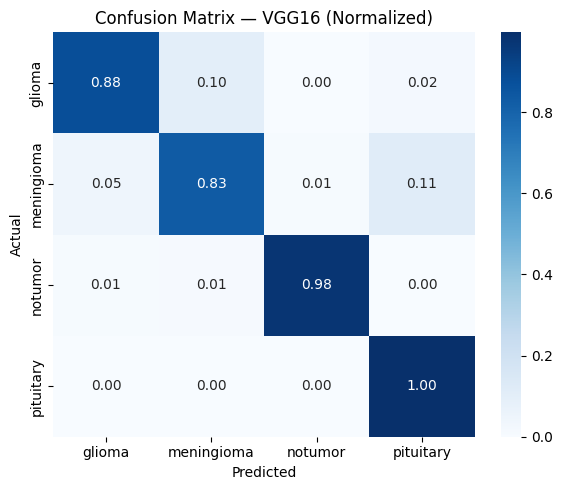


📊 DenseNet121 + GWO + SVM Classification Report

              precision    recall  f1-score   support

      glioma       0.30      0.09      0.14       212
  meningioma       0.27      0.13      0.18       215
     notumor       0.29      0.57      0.38       255
   pituitary       0.32      0.33      0.32       233

    accuracy                           0.29       915
   macro avg       0.29      0.28      0.25       915
weighted avg       0.29      0.29      0.26       915



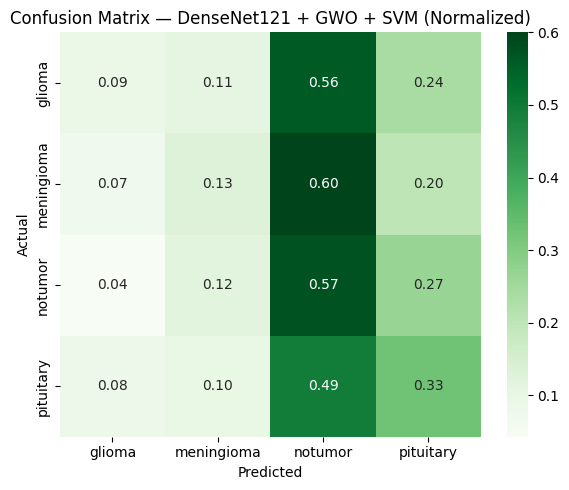

In [ ]:
# ==============================
# CONFUSION MATRICES + REPORTS
# ==============================


# ------------------------------
# CLASS NAMES
# ------------------------------
class_names = list(vgg_test_generator.class_indices.keys())

# =====================================================
# 1️⃣ VGG16 — Classification Report + Confusion Matrix
# =====================================================

# Ground truth
y_true_vgg = vgg_test_generator.classes

# Predictions
y_pred_vgg = np.argmax(
    vgg_model.predict(vgg_test_generator, verbose=0),
    axis=1
)

print("\n📊 VGG16 Classification Report\n")
print(
    classification_report(
        y_true_vgg,
        y_pred_vgg,
        target_names=class_names,
        zero_division=0
    )
)

# Normalized confusion matrix
cm_vgg = confusion_matrix(
    y_true_vgg,
    y_pred_vgg,
    normalize='true'
)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_vgg,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix — VGG16 (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# =====================================================
# 2️⃣ DenseNet121 + GWO + SVM — Report + Confusion Matrix
# =====================================================

# Predictions from SVM
y_pred_gwo = svm.predict(X_test)

print("\n📊 DenseNet121 + GWO + SVM Classification Report\n")
print(
    classification_report(
        y_test,
        y_pred_gwo,
        target_names=class_names,
        zero_division=0
    )
)

# Normalized confusion matrix
cm_gwo = confusion_matrix(
    y_test,
    y_pred_gwo,
    normalize='true'
)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_gwo,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix — DenseNet121 + GWO + SVM (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


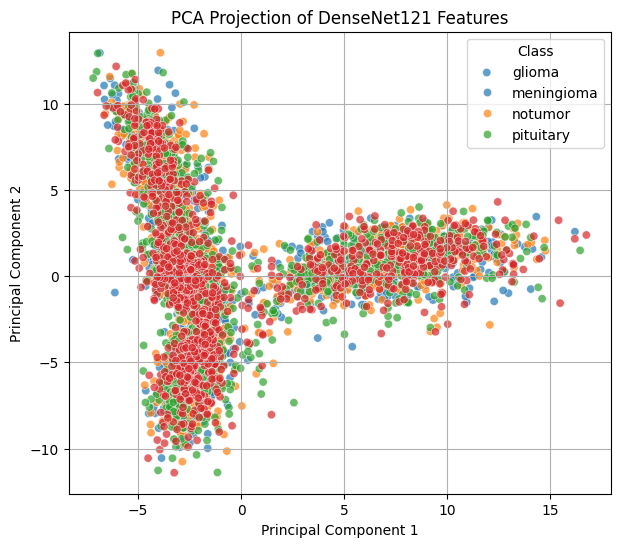

In [ ]:
# ==============================
# FEATURE SPACE VISUALIZATION
# PCA & t-SNE
# ==============================

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Use DenseNet features (before GWO)
X = densenet_features
y = labels

class_names = list(cnn_train_generator.class_indices.keys())

# ------------------------------
# PCA (2D)
# ------------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(7, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=y,
    palette="tab10",
    alpha=0.7,
    legend="full"
)
plt.title("PCA Projection of DenseNet121 Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class", labels=class_names)
plt.grid(True)
plt.show()
